## Portfolio Assignment week 03

This week's focus is on anomaly detection. As part of the portfolio assignment, you are required to make a contribution using anomaly detection algorithm(s). There are several options for your contribution, so you can choose the one that aligns with your learning style or interests the most

## Anomaly Detection

Anomaly detection in machine learning refers to the process of identifying patterns or instances in a dataset that deviate significantly from the norm or expected behavior. Anomalies, also known as outliers, are data points that are rare, unusual, or don't conform to the typical patterns observed in the majority of the data. Anomaly detection algorithms aim to automatically detect these anomalies. Anomaly detection in machine learning has various applications across domains, including predictive maintenance, and healthcare monitoring. By automatically identifying anomalies, these algorithms help in detecting potential risks. 


## Anomaly Detection Assignment

Study the notebook `Study_Case_Anomoly_Detection` 

Choose at least 1 out of the listed assignments below

- Analyze the end result plot to evaluate the algorithm's performance. Look for anomalies identified by the algorithm and compare them to known anomalies or instances of abnormal behavior in the data. Assess whether the algorithm successfully captures these anomalies and if it shows promising results in detecting abnormal patterns. Based on the plot analysis, provide argumentation for the validity of the anomaly detection algorithm hypothesis (see above). Discuss how the algorithm effectively captures anomalies in the time series data and why it is a suitable approach for the use case. Support your argument with references to relevant literature that discuss the effectiveness of the chosen algorithm or similar algorithms in detecting anomalies in time series data.
- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook.
- Try another algorithm that has not been tested in the notebook. Provide argumentation for the validity of the anomaly detection algorithm you choose.
- Try to find the best configuration for one of the tested algorithms
- Try anomaly detection on a different dataset without timeseries data. Intrepret the results

Do not forget to reference sources!

---

used as reference material:
https://scikit-learn.org/stable/modules/outlier_detection.html

In [3]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import yaml
plt.style.use("dark_background")

In [4]:
# load the data
with open('config.yaml', 'r') as conf:
    config = yaml.load(conf, yaml.SafeLoader)

sensor_data = pd.read_csv(config['sensor_data']) #from https://www.kaggle.com/datasets/nphantawee/pump-sensor-data

In [5]:
sensor_data = sensor_data.drop(columns='Unnamed: 0')

sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [6]:
#missing values from the Example notebook. Good code
percentage_missing = sensor_data.isnull().sum().sort_values(ascending=False)/len(sensor_data)*100
percentage_missing.head() # show 5 largest missing %

# dropping low quality sensors
sensor_data.drop(columns=['sensor_15','sensor_50'], inplace= True)


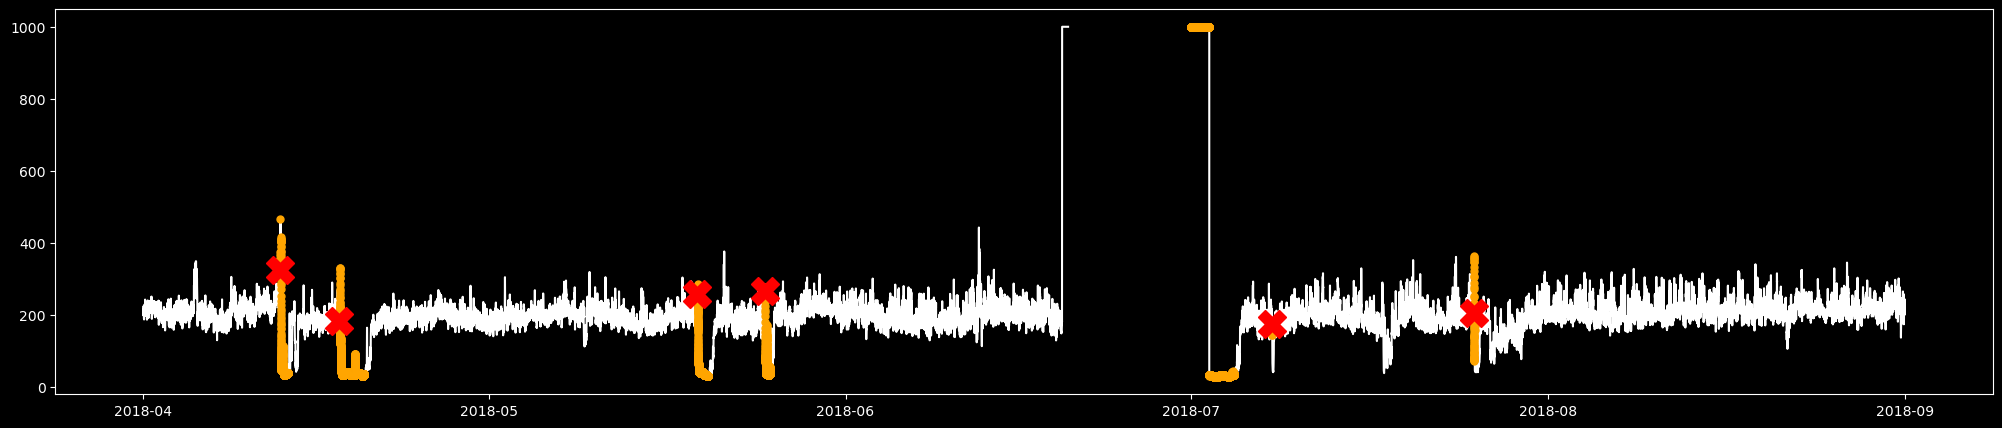

In [7]:
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
sensor_data.set_index('timestamp', inplace=True)


broken = sensor_data[sensor_data["machine_status"] == 'BROKEN']
recovery = sensor_data[sensor_data["machine_status"] == 'RECOVERING']
normal = sensor_data[sensor_data["machine_status"] == 'NORMAL']


def sensor_plot(sensor):
    fig, ax = plt.subplots(figsize=(25,5))
    ax.plot(sensor_data[sensor], color='white')
    ax.plot(recovery[sensor], linestyle='none', color='orange', marker='o', markersize=5)
    ax.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=20)
    plt.show()

sensor_plot('sensor_51')


In [8]:
#filling NA and scaling the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X = sensor_data.iloc[:,1:-1] # obviously we should not include time data
X = X.fillna(X.mean())
X = scaler.fit_transform(X)

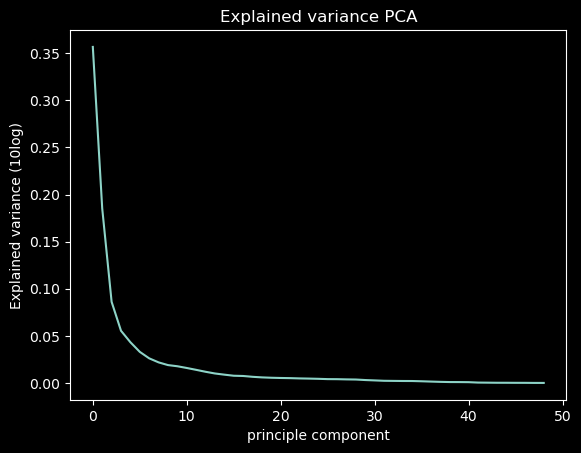

In [9]:
# because there are a lot of columns (sensors) and rows. It may be best to do dimensionality reduction using PCA
# first the number of components will be selected according to the 
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

plt.plot(pca.explained_variance_ratio_)
plt.title("Explained variance PCA")
plt.xlabel("principle component")
plt.ylabel("Explained variance (10log)")
plt.show()



In [10]:
# about 5/6 should be enough to get the lot of the variance. 
# eventually reduced it to only two principle components.

X = pca.transform(X)[:,:2]

X_train, X_test = X[:-20000], X[-20000:]


In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


outliers_fraction = 1 - (len(normal)/(len(sensor_data))) # where the machine is either broken or recovering. 
isfo = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
loof = LocalOutlierFactor(novelty=True, n_neighbors=250)
ocsv = OneClassSVM(nu=0.5)

isfo.fit(X_train)
loof.fit(X_train)
ocsv.fit(X_train)

ypred_isfo = isfo.predict(X)
ypred_loof = loof.predict(X)
ypred_ocsv = ocsv.predict(X)

#from joblib import dump

#dump(isfo, "Isfo_classifier.joblib" )




In [12]:
sensor_data["IsFo"] = ypred_isfo
sensor_data["loof"] = ypred_loof
sensor_data["ocsv"] = ypred_loof

anomaly_isfo = sensor_data[sensor_data['IsFo'] == -1]
anomaly_loof = sensor_data[sensor_data['loof'] == -1]
anomaly_ocsv = sensor_data[sensor_data['ocsv'] == -1]

def sensor_plot_pred(sensor):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(sensor_data[sensor], color='white')
    ax.plot(recovery[sensor], color='pink', linestyle='none', marker='X',markersize=20)
    ax.plot(anomaly_isfo[sensor], linestyle='none', marker = 'o', color = 'blue',markersize=15)
    ax.plot(anomaly_loof[sensor], linestyle='none', marker = 'o', color = 'orange', markersize=15)
    ax.plot(anomaly_ocsv[sensor], linestyle='none', marker = 'o', color = 'cyan')
    ax.set_title(sensor)
    ax.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=30)

    plt.show()

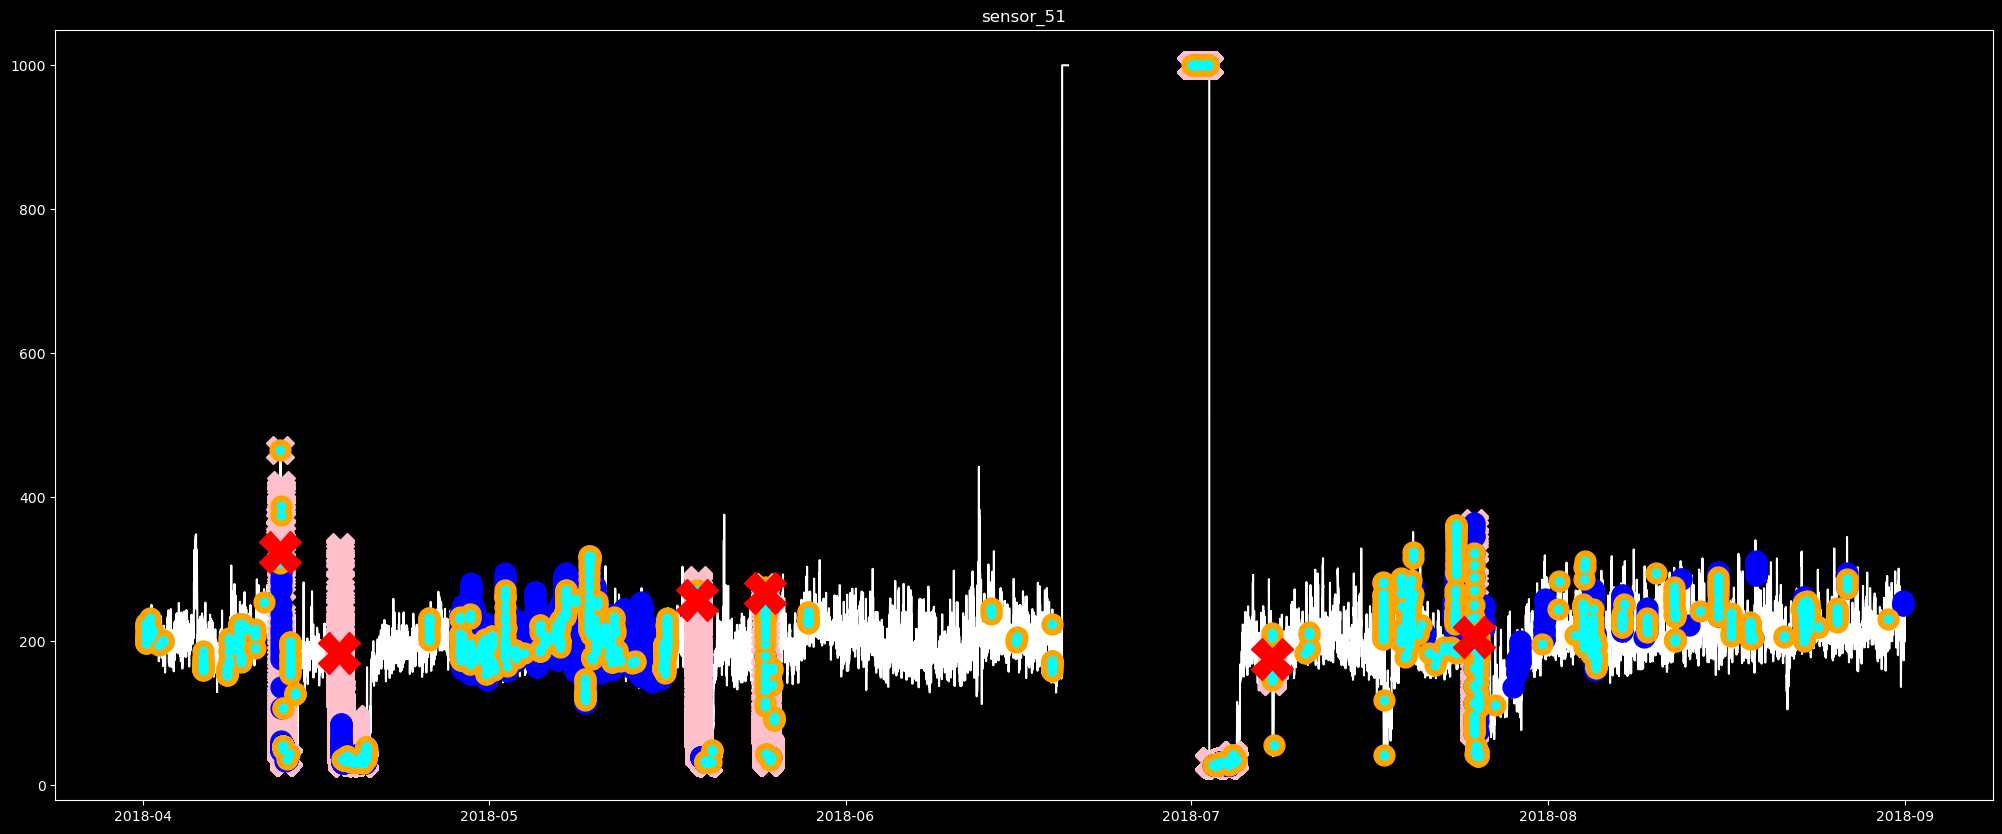

In [13]:
sensor_plot_pred('sensor_51')

First I tried the prediction without the dimensionality reduction, then with 6 principle components but that did not make it any better. 3 was also not better. 2 seemed to work best. 
It seems that outliers are found, but direct correlation is hard. Maybe a supervised method focussed on the recovery/breakdown, or the period before. the predictions are especially bad for the data that it did not train on (so the last 20.000 rows)

Either the orange or cyan seems to be the best prediction. So that will be local outlier factor or one class SVM. Since LOF is faster to train, it will be preferable. 

--- 

# Anomaly detection Credit card fraud

Using credit card spending data to dectect credit card theft or fraud would be a
great use case for unsupervised machine learning anomaly detection. I think.

Using the following dataset from kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [14]:
creditcard_df = pd.read_csv(config["credit_card"])

creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [15]:
creditcard_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [16]:
#missing values from the Example notebook. Again, stolen. Shame on me. 
percentage_missing = creditcard_df.isnull().sum().sort_values(ascending=False)/len(sensor_data)*100
percentage_missing.head() # show 5 largest missing %

Time      0.0
V16       0.0
Amount    0.0
V28       0.0
V27       0.0
dtype: float64

It seems the data has no missing values. According to the description on kaggle the values in V1-28 are a result of anonymizing by decomposition of the original values with PCA. In the class column 1 means fraud 0 means no fraud detected. There is also a column with amount that is not transformed with PCA. We will not use the amount column.

In [17]:
X = creditcard_df.iloc[:,1:-2]

In [18]:
#The best performer in the previous dataset was LOF. Lets try it on this set and optimize the hyperparameters.
# without cross validation, so we cannot use GridSearch here. ParameterGrid however
# makes it easy to create multiple parameter dictionaries. 
from sklearn.model_selection import ParameterGrid

hyperparams = {
                "n_neighbors":[500,1000,1500],
                "algorithm":['auto'],
                "novelty":[True]
                } 
#lets initialize and fit the different LOF 
lofs = [LocalOutlierFactor(**params) for params in list(ParameterGrid(hyperparams))]

lofs= [lof.fit(X) for lof in lofs]

In [19]:
# predict outliers for the whole dataset 
lof_predictions = [lof.predict(X) for lof in lofs]

for c, prediction in enumerate(lof_predictions):
    creditcard_df[f'prediction_{c+1}'] = prediction


/opt/miniconda3/envs/testenvironment/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/testenvironment/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/testenvironment/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [20]:
creditcard_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,prediction_1,prediction_2,prediction_3
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1,1,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1,1,1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,1,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1,1,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1,-1,-1
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1,1,1
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1,1,1
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1,1,1


In [21]:
# funtion to get the accuracy score of the predictions
# I know there is a sklearn function for this, but I like my own function from week 6 better

def get_score(test_y, pred_y):
    false_pred = 0
    for p,y in zip(pred_y, test_y):
        match p:
            case -1:
                p = 1
            case _:
                p = 0
        if p != y:
            false_pred += 1
    return 1 - false_pred / len(pred_y)
    



In [22]:
for c,params in zip(range(27),list(ParameterGrid(hyperparams))):
    print(f"{params}: {get_score(creditcard_df['Class'].values,creditcard_df[f'prediction_{c+1}'])*100:.003}%")

{'algorithm': 'auto', 'n_neighbors': 500, 'novelty': True}: 96.0%
{'algorithm': 'auto', 'n_neighbors': 1000, 'novelty': True}: 96.5%
{'algorithm': 'auto', 'n_neighbors': 1500, 'novelty': True}: 96.3%


As shown in the scores above, it seems that a higher number of neighbors account for a better prediction reaching an accuracy of 88.2%. The leaf_size or algorithm did not really have an impact. 
There is one thing we should be aware of because the 'anomaly', fraud in this case is only in a really small amount of the cases. 0.147%! Even if everything was negative, it would still have an accuracy of 98,853% .

A confusion matrix would be better suited in this case.

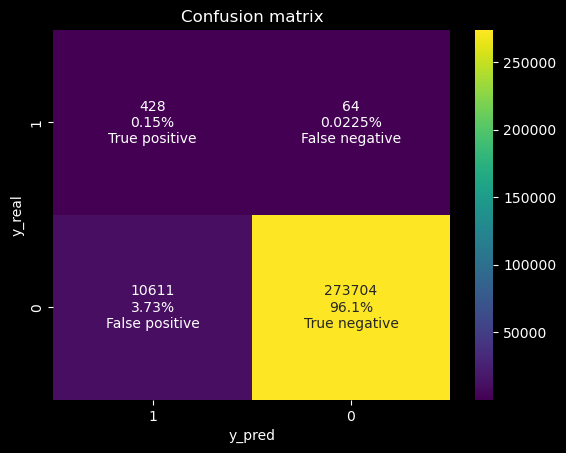

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix([-1 if value == 1 else 1 for value in creditcard_df["Class"].values], creditcard_df["prediction_3"])

pred_labels = ["True positive","False negative","False positive","True negative"]
counts = [value for value in
                cf_matrix.flatten()]
group_percentages = [f"{value *100:.03}%" for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{count}\n{percentage}\n{pred_label}" for count, percentage, pred_label in
          zip(counts,group_percentages,pred_labels)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='viridis')
plt.xticks([.5,1.5],[1,0])
plt.xlabel("y_pred")
plt.ylabel("y_real")
plt.yticks([.5,1.5],[1,0])
plt.title("Confusion matrix")
plt.show()

It seems that the prediction of credit card fraud with this method is faulty.
The amount of false positives are way too high, and preferably you want as few as possible.
As you do not want to do all the rest of the work yourself or falsely accuse someone of fraud.

because this was already a labeled dataset, a supervised approach would suit better. 
This also applies to the sensor data. 
However with a supervised approach one should manage the unbalance in the dataset. 
And maybe for training purpose I should have done that here as well. 
